In [1]:
from concurrent.futures import ProcessPoolExecutor
from dataclasses import dataclass
from pathlib import Path

import cv2
import IPython.display as ipd
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from enum import Enum
from pprint import pprint
import torchaudio
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F_vision
import pickle

In [2]:
data_dir = Path("./data/")

In [3]:
class Split(Enum):
    TRAIN = 1
    VALIDATION = 2
    TEST = 3


class Sentiment(Enum):
    POSITIVE = 1
    NEUTRAL = 2
    NEGATIVE = 3


@dataclass
class Metadata:
    path: str
    video_id: str
    clip_id: int
    duration: float
    # VISUAL INFO
    width: int
    height: int
    # AUDIO INFO
    sample_rate: int
    channels: int
    # TEXT INFO
    text: str
    sentiment_score: float
    sentiment: Sentiment
    split: Split

    def get_cv2_capture(self) -> cv2.VideoCapture:
        return cv2.VideoCapture(self.path)

    def play_video(self):
        pprint(self)
        return ipd.Video(self.path)

    def get_video_frames(self, fps=10) -> np.ndarray:
        # note that due to the variable nature of FPS in encoded video,
        # the fps argument is only approximate for this function
        cap = self.get_cv2_capture()
        if not cap.isOpened():
            print("Error opening video file")

        frame_interval = 1.0 / fps  # interval in seconds

        frames = []
        last_capture_time = -frame_interval

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Get the current time of the frame in the video
            current_time = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0  # convert to seconds

            # Check if the current frame is due for capture based on desired FPS
            if current_time >= (last_capture_time + frame_interval):
                frames.append(frame)
                last_capture_time = current_time

        cap.release()
        frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]
        return np.array(frames)

    def get_audio(self) -> np.ndarray:
        audio, sample_rate = torchaudio.load(self.path)
        return audio, sample_rate


class RawDataset:
    def __init__(
        self,
        data_dir: Path,
        dataset_name: str,
        max_workers: int = 8,
        debug: bool = False,
    ):
        self.dataset_dir = Path(data_dir) / dataset_name
        self.labels = pd.read_csv(self.dataset_dir / "label.csv")
        if debug:
            max_workers = 1
            self.labels = self.labels.sample(n=100)
        if max_workers > 1:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                splits = np.array_split(self.labels, max_workers)
                results = list(executor.map(self.build_video_sublist, splits))
            self.merge_subdicts(results)
        else:
            self.videos = self.build_video_sublist(self.labels)

    def merge_subdicts(self, results: list[dict, set]):
        self.videos = []
        for videos in results:
            self.videos += videos

    def read_video_metadata(self, video_path: Path, row) -> Metadata:
        # VIDEO METADATA
        vid = cv2.VideoCapture(filename=str(video_path))
        width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # AUDIO METADATA
        audio, sample_rate = torchaudio.load(str(video_path), normalize=False)
        channels, audio_sample_count = audio.shape
        duration = audio_sample_count / sample_rate

        # LABELS
        if row.annotation == "Positive":
            sentiment = Sentiment.POSITIVE
        elif row.annotation == "Neutral":
            sentiment = Sentiment.NEUTRAL
        elif row.annotation == "Negative":
            sentiment = Sentiment.NEGATIVE
        else:
            raise ValueError(f"{row.annotation=} not recognized")

        # SPLIT
        if row.mode == "train":
            split = Split.TRAIN
        elif row.mode == "valid":
            split = Split.VALIDATION
        elif row.mode == "test":
            split = Split.TEST
        else:
            raise ValueError(f"{row.mode=} not recognized")

        return Metadata(
            path=str(video_path),
            duration=duration,
            width=width,
            height=height,
            sample_rate=sample_rate,
            channels=channels,
            video_id=row.video_id,
            clip_id=row.clip_id,
            text=row.text,
            sentiment_score=row.label,
            sentiment=sentiment,
            split=split,
        )

    def build_video_sublist(self, df: pd.DataFrame):
        videos = []
        for row in df.itertuples():
            video_path = self.dataset_dir / "Raw" / row.video_id / f"{row.clip_id}.mp4"
            assert video_path.exists(), f"{video_path=} does not exist"
            videos.append(self.read_video_metadata(video_path=video_path, row=row))
        return videos

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, key):
        return self.videos[key]

In [6]:
dataset = RawDataset(data_dir=data_dir, dataset_name="CH-SIMS", debug=False)
with open('./data/CH-SIMS.pkl', 'wb') as f:
    pickle.dump(dataset, f)

/home/kaandonbekci/miniconda3/envs/ccu/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
# with open('./data/CMU-MOSEI.pkl', 'rb') as f:
#     dataset = pickle.load(f)

In [7]:
len(dataset)

4403

In [57]:
metadata = dataset[10]

In [58]:
metadata.play_video()

Metadata(path='data/CH-SIMS/Raw/video_0001/0011.mp4',
         video_id='video_0001',
         clip_id='0011',
         duration=2.1333333333333333,
         width=1920,
         height=804,
         sample_rate=48000,
         channels=2,
         text='友德读懂了您对我的暗示。',
         sentiment_score=1.0,
         sentiment=<Sentiment.POSITIVE: 1>,
         split=<Split.TRAIN: 1>)


In [10]:
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model

feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)
audio_model = Wav2Vec2Model.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", cache_dir="models/"
).cuda()

In [11]:
def extract_audio_embedding(audio, sr):
    audio = audio.mean(dim=0)
    resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16_000)
    audio = resampler(audio)
    audio = feature_extractor(
        audio, sampling_rate=16_000, return_tensors="pt"
    ).input_values.cuda()
    with torch.no_grad():
        audio_embeddings = audio_model(audio).last_hidden_state.cpu().squeeze()
    return audio_embeddings

In [13]:
extract_audio_embedding(*metadata.get_audio()).shape

torch.Size([152, 1024])

In [64]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel

tokenizer = XLMRobertaTokenizer.from_pretrained(
    "xlm-roberta-base", cache_dir="models/"
)
text_model = XLMRobertaModel.from_pretrained(
    "xlm-roberta-base", cache_dir="models/"
).cuda()

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [15]:
def extract_text_embedding(text: str):
    encoded_input = tokenizer(text, return_tensors="pt")
    encoded_input = {key: val.cuda() for key, val in encoded_input.items()}
    with torch.no_grad():
        text_embeddings = text_model(**encoded_input).last_hidden_state.cpu().squeeze()
    return text_embeddings

In [16]:
# prepare input
extract_text_embedding(metadata.text).shape

torch.Size([6, 1024])

In [18]:
from batch_face import RetinaFace
from models_multiview import FrontaliseModelMasks_wider

detector = RetinaFace(0, model_path='./models/RetinaFace/mobilenet0.25_Final.pth')
visual_model = FrontaliseModelMasks_wider(
    input_nc=3, inner_nc=256, num_additional_ids=32
)
visual_model.load_state_dict(
    torch.load("./models/fabnet/affectnet_4views.pth")["state_dict_model"]
)
visual_model = visual_model.eval().cuda()

32 256


In [19]:
def find_largest_face(faces: list):
    ix = -1
    max_area = -1
    for i, face in enumerate(faces):
        bbox, _, conf = face
        if conf < 0.99:
            continue
        face_width = bbox[2] - bbox[0]
        face_height = bbox[3] - bbox[1]
        face_area = face_width * face_height
        if face_area > max_area:
            ix = i
            max_area = face_area

    if ix != -1:
        return faces[ix]
    return None

In [50]:
MIN_FACE_WIDTH = 30
MIN_FACE_HEIGHT = 60
MIN_FACE_CONFIDENCE = 0.95


def check_faces(faces: list):
    if len(faces) != 1:
        face = find_largest_face(faces)
        if face is None:
            return None
    else:
        face = faces[0]
    bbox, _, conf = face
    if conf < MIN_FACE_CONFIDENCE:
        return None
    face_width = bbox[2] - bbox[0]
    face_height = bbox[3] - bbox[1]
    if face_width < MIN_FACE_WIDTH:
        return None
    elif face_height < MIN_FACE_HEIGHT:
        return None
    return bbox.round().astype(int)

In [51]:
def crop_face(frame_face):
    frame, face = frame_face
    # frame = (height, width, channels)
    # face = (x_start, y_start, x_end, y_end)
    x_start, y_start, x_end, y_end = face
    x_center = (x_start + x_end) / 2
    y_center = (y_start + y_end) / 2

    width = x_end - x_start
    height = y_end - y_start
    if width > height:
        length = width
    else:
        length = height

    pad = int(length * 0.2)

    padded_x_start = int(x_center - length / 2 - pad)

    padded_y_start = int(y_center - length / 2 - pad)

    frame = torch.tensor(frame).permute(2, 0, 1)
    face_frame = F_vision.resized_crop(
        frame,
        top=padded_y_start,
        left=padded_x_start,
        height=length + 2 * pad,
        width=length + 2 * pad,
        size=[256, 256],
        antialias=True,
    )
    return face_frame

In [52]:
def extract_visual_embedding(frames):
    faces_in_frames = detector.detect(frames, chunk_size=frames.shape[0])
    faces_in_frames = map(check_faces, faces_in_frames)
    face_frames = list(
        map(
            crop_face,
            filter(
                lambda frame_face: frame_face[1] is not None,
                zip(frames, faces_in_frames),
            ),
        )
    )
    if len(face_frames) < 5:
        print("Failed!")
        return None
    face_frames = torch.stack(face_frames)
    face_frames_cuda = F_vision.convert_image_dtype(face_frames).cuda()
    with torch.no_grad():
        visual_embeddings = visual_model.encoder(face_frames_cuda).cpu().squeeze()
    return visual_embeddings, face_frames.permute(0, 2,3, 1)

In [59]:
visual_embedding, face_frames = extract_visual_embedding(metadata.get_video_frames(fps=5))

In [60]:
visual_embedding.shape

torch.Size([11, 256])

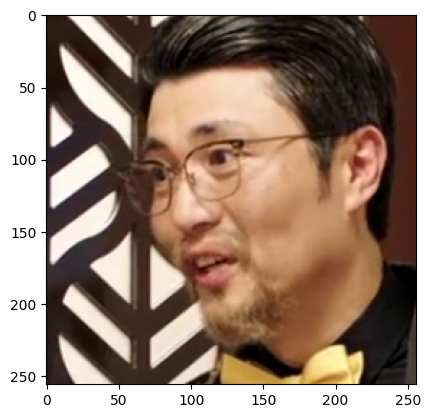

In [63]:
plt.imshow(face_frames[4])

In [45]:
@dataclass
class Datum:
    metadata: Metadata
    audio_embedding: torch.FloatTensor
    visual_embedding: torch.FloatTensor
    text_embedding: torch.FloatTensor

In [ ]:
X = []
for i, metadata in enumerate(tqdm(dataset)):
    if metadata.duration > 10:
        continue
    visual_embedding = extract_visual_embedding(metadata.get_video_frames(fps=5))
    if visual_embedding is None:
        print(i)
        continue
    audio_embedding = extract_audio_embedding(*metadata.get_audio())
    text_embedding = extract_text_embedding(metadata.text)
    X.append(
        Datum(
            metadata=metadata,
            audio_embedding=audio_embedding,
            visual_embedding=visual_embedding,
            text_embedding=text_embedding,
        )
    )
print(f'{len(X) = }')

  0%|                                     | 20/22856 [00:31<10:44:01,  1.69s/it]

Failed!
19


  0%|                                      | 22/22856 [00:33<8:59:12,  1.42s/it]

Failed!
21


  0%|                                      | 23/22856 [00:34<8:42:31,  1.37s/it]

Failed!
22


  0%|                                      | 30/22856 [00:37<3:52:11,  1.64it/s]